<a href="https://colab.research.google.com/github/utkarsh0702/Projects/blob/master/Pothole_detection_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import os
from tensorflow import keras
import zipfile
from google.colab import files

In [16]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
local_zip= '/content/drive/My Drive/datasets/Pothole Dataset.zip'
zip_ref= zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [0]:
train_pos_dir= os.path.join('/content/Pothole Dataset/Train/Positive')
train_neg_dir= os.path.join('/content/Pothole Dataset/Train/Negative')
test_pos_dir= os.path.join('/content/Pothole Dataset/Test/Positive')
test_neg_dir= os.path.join('/content/Pothole Dataset/Test/Negative')

In [20]:
print('Total train Positive images: ',len(os.listdir(train_pos_dir)))
print('Total train Negative images: ',len(os.listdir(train_neg_dir)))
print('Total test Positive images: ',len(os.listdir(test_pos_dir)))
print('Total test Negative images: ',len(os.listdir(test_neg_dir)))

Total train Positive images:  597
Total train Negative images:  606
Total test Positive images:  183
Total test Negative images:  148


In [21]:
feature_extractor = keras.applications.MobileNet(input_shape=(300,300,3),
                                      include_top=False,
                                      weights='imagenet')
feature_extractor.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 301, 301, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 150, 150, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 150, 150, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 150, 150, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 150, 150, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 150, 150, 32

In [37]:
model2= keras.Sequential([
                         feature_extractor,
                         keras.layers.GlobalAveragePooling2D(),
                         keras.layers.Flatten(),
                         keras.layers.Dense(256, activation="relu"),
                         keras.layers.Dropout(0.4),
                         keras.layers.Dense(512, activation="relu", activity_regularizer= keras.regularizers.l1(0.01)),
                         keras.layers.Dropout(0.4),
                         keras.layers.Dense(2, activation= "sigmoid")
])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 9, 9, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [0]:
num_layers= 10
feature_extractor.trainable= True;
for Layers in model2.layers[-num_layers:]:
  Layers.trainable= True

In [0]:
model2.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.01, name='Adam'),
    loss= keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_gen= train_datagen.flow_from_directory( '/content/Pothole Dataset/Train',
                                             target_size=(300,300),
                                            batch_size=25,
                                            class_mode='categorical',
                                             shuffle= True)

test_datagen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_gen= test_datagen.flow_from_directory( '/content/Pothole Dataset/Test',
                                           target_size=(300,300),
                                            batch_size=7,
                                            class_mode='categorical',
                                           shuffle=True)

Found 1203 images belonging to 2 classes.
Found 331 images belonging to 2 classes.


In [0]:
class myCall(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.8 and logs.get('val_loss')<0.5):
      print('\nThe Training is Cancelled.....')
      self.model.stop_training= True

callback= myCall()

In [45]:
history1= model2.fit_generator( train_gen,
                   steps_per_epoch=50,
                   epochs=20,
                   validation_data= test_gen,
                   validation_steps= 50,
                   verbose=2,
                   callbacks=[callback])

Epoch 1/20
Epoch 1/20
50/50 - 62s - loss: 3.0566 - acc: 0.6609
50/50 - 206s - loss: 0.3515 - acc: 0.8795 - val_loss: 3.0566 - val_acc: 0.6609
Epoch 2/20
Epoch 1/20
50/50 - 62s - loss: 1.0119 - acc: 0.7188
50/50 - 177s - loss: 0.2515 - acc: 0.9544 - val_loss: 1.0119 - val_acc: 0.7188
Epoch 3/20
Epoch 1/20
50/50 - 62s - loss: 3.8332 - acc: 0.5826
50/50 - 172s - loss: 0.2625 - acc: 0.9502 - val_loss: 3.8332 - val_acc: 0.5826
Epoch 4/20
Epoch 1/20
50/50 - 62s - loss: 1.6111 - acc: 0.6841
50/50 - 178s - loss: 0.1777 - acc: 0.9688 - val_loss: 1.6111 - val_acc: 0.6841
Epoch 5/20
Epoch 1/20
50/50 - 61s - loss: 0.6625 - acc: 0.6841
50/50 - 175s - loss: 0.1436 - acc: 0.9739 - val_loss: 0.6625 - val_acc: 0.6841
Epoch 6/20
Epoch 1/20
50/50 - 62s - loss: 0.6850 - acc: 0.6899
50/50 - 176s - loss: 0.1934 - acc: 0.9577 - val_loss: 0.6850 - val_acc: 0.6899
Epoch 7/20
Epoch 1/20
50/50 - 63s - loss: 0.9168 - acc: 0.6551
50/50 - 176s - loss: 0.1387 - acc: 0.9756 - val_loss: 0.9168 - val_acc: 0.6551
Epoch 

In [0]:
import matplotlib.pyplot as plt


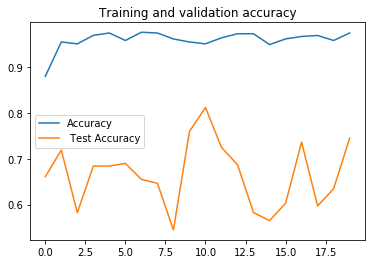

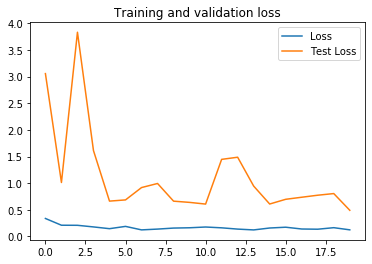

In [47]:
acc= history1.history['acc']
val_acc= history1.history['val_acc']
loss= history1.history['loss']
val_loss= history1.history['val_loss']

epochs= range(len(acc))
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, label=' Test Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, label='Test Loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.show()

In [0]:
import pathlib
import tensorflow as tf

In [49]:
export_dir= '/content/saved_model'
tf.saved_model.save(model2, export_dir)

INFO:tensorflow:Assets written to: /content/saved_model/assets


In [50]:
#converting and quantizing the model
converter= tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.allow_custom_ops= True
converter.optimization=[tf.lite.Optimize.DEFAULT]
tflite_model= converter.convert()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /content/saved_model/variables/variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: mobilenet_1.00_224_input
INFO:tensorflow: tensor name: serving_default_mobilenet_1.00_224_input:0, shape: (-1, 300, 300, 3), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_14
INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 2), type: DT_FLOAT
INFO:tensorflow:Restoring parameters from /content/saved_model/variables/variables
Instructions f

Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the f

In [51]:
#save the model
tflite_model_file= pathlib.Path('/content/drive/My Drive/PD_transfer_learning_latest.tflite')
tflite_model_file.write_bytes( tflite_model )

14382464

In [52]:
print(model)